## Alpaca Automated Stock Trading

> Moving strategy from R to the native python API client

### Strategy Parameters
1. N_DAYS_AGO
    - How many days of historical data to pull each run
2. OLS_Window
    - Rolling window for various alpha / beta calculations
3. Total_Market_Plot_SMA
    - Window for rolling simple moving average on Total Market plot. 
    - I prefer to keep this the same as the OLS_Window parameter

In [1]:
## Warning Handling
import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")
warnings.filterwarnings("ignore", message="Mean of empty slice.")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")

In [2]:
N_DAYS_AGO = 91
OLS_Window = 5
Total_Market_Plot_SMA = OLS_Window
CAP = 'All'
min_list_years = 5
min_volume = 400000
max_investment = 110
min_investment = 15

In [17]:
## Installing Required Packages
import sys
import time
import math
import pickle
import alpaca_trade_api as tradeapi
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

## Setting Project Folder
Project_Folder = "C://Users//" + os.getlogin() + "//documents//github//Stock-Strategy-Exploration//"

## Pulling API Keys
Keys = pd.read_csv(os.path.join('..','Data','Keys','Live API.txt'))

## Connecting to Alpaca
api = tradeapi.REST(Keys['Key ID'][0],Keys['Secret Key'][0], api_version='v2')

## API Initial Set Up
### Get Current Account Information
account = api.get_account()

## Reading In Functions
Function_Files = os.listdir('Functions')
for File in Function_Files:
    if '.py' in File:
        print(File)
        Full_File = 'Functions/'+File
        exec(open(Full_File).read())
        
def years_listed(d1):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.today()
    return abs((d2 - d1).days/365)

Group_Consolidator.py
Stock_Consolidator.py
Technical_Indicators.py


### Historical Data Pull

In [ ]:
### List of Tradable Assets
assets = api.list_assets("active")
Final_Assets = [i._raw['symbol'] for i in assets if i._raw['tradable'] & i._raw['shortable']  & i._raw['easy_to_borrow']]

## Amount of Historical Data to Pull
start_date = datetime.now() - timedelta(days=N_DAYS_AGO)
Historical_Data = defaultdict(pd.DataFrame)

## Pulling Historical Data
counter = 0
for i in tqdm(Final_Assets):
    try:        
        Company_Info = api.polygon.company(i)
        yl = years_listed(Company_Info.listdate)
        mc = Company_Info.marketcap / 1e06
        if mc < 300.:
            Cap = 'Micro'
        elif mc >= 300. and mc < 2000.:
            Cap = 'Small'
        elif mc >= 2000. and mc < 10000.:
            Cap = 'Mid'
        else:
            Cap = 'Large'
        
        if CAP != "All":
            if Cap != CAP:
                raise Exception("Skipping wrong market cap")
        if yl < min_list_years:
            raise Exception("Skipping comapny to new")
        
        TMP = api.polygon.historic_agg_v2(i, 1, 'day', _from=start_date.strftime("%Y-%m-%d"), to=datetime.now().strftime("%Y-%m-%d")).df
        
        if np.mean(TMP['close'].tail(50)) > max_investment:
            raise Exception("Price Beyond Acceptable Investment")
        if np.mean(TMP['close'].tail(50)) < min_investment:
            raise Exception("Price Beyond Acceptable Investment")
        if np.mean(TMP['volume'].tail(50)) < min_volume:
            raise Exception("Not Enough Liquidity")
        
        TMP['market_cap'] = Cap    
        TMP['date'] = TMP.index
        TMP['sector'] = Company_Info.sector
        TMP['industry'] = Company_Info.industry
        Historical_Data[i] = TMP 
    except:
        counter += 1

print(str(counter) + " Symbols Failed During Data Pull")
## Adding Stock Attribute Before Combining
for s in Historical_Data:
    Historical_Data[s].insert(0, 'stock', [s]*len(Historical_Data[s]))

## Combining Data To Single Data Frame
Combined_Data = pd.concat(Historical_Data.values())  
Combined_Data = Combined_Data[Combined_Data['sector'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['sector'])]
Combined_Data = Combined_Data[Combined_Data['industry'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['industry'])]

## Saving Data
pickle.dump(Combined_Data, open(Project_Folder + "Data//Historical_Data.p" , "wb" ) )

From cffi callback <function _verify_callback at 0x000001E08B866CA0>:
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\envs\GTU\lib\site-packages\OpenSSL\SSL.py", line 311, in wrapper
    @wraps(callback)
KeyboardInterrupt


### Exploring Total Market Performance

In [6]:
## Loading Stored Data
Combined_Data = pickle.load(open(Project_Folder + "Data//Historical_Data.p" , "rb" ))
Combined_Data = Combined_Data.drop_duplicates()

Total_Market = Stock_Consolidator(Combined_Data)
Total_Market = Total_Market.loc[Total_Market.RSI > 0,:]
Total_Market.head(5)

,close,volume,count,close_diff,close_return,volume_diff,sma,RSI,MACD,sma_ret,sd_ret
date,,,,,,,,,,,
2020-07-24 00:00:00-04:00,45.907114,2.338139e+06,856.0,-0.009583,0.002141,-0.118990,46.103806,58.036893,0.163303,0.001652,0.012746
2020-07-27 00:00:00-04:00,46.335654,2.355710e+06,856.0,0.009335,0.014876,0.007515,46.239646,57.692960,0.150622,0.003571,0.011609
2020-07-28 00:00:00-04:00,45.973511,3.376113e+06,856.0,-0.007816,-0.003713,0.433162,46.205379,61.462824,0.108499,0.002511,0.011942
2020-07-29 00:00:00-04:00,46.778254,4.143659e+06,856.0,0.017504,0.006865,0.227346,46.269171,62.450184,0.124352,0.004963,0.011165
2020-07-30 00:00:00-04:00,46.477921,3.942563e+06,856.0,-0.006420,0.002731,-0.048531,46.294491,68.925455,0.104905,0.003504,0.011226


In [14]:
np.round(np.std(Total_Market['close_diff'][Total_Market['close_diff'] > 0].tail(14)),3)

0.006

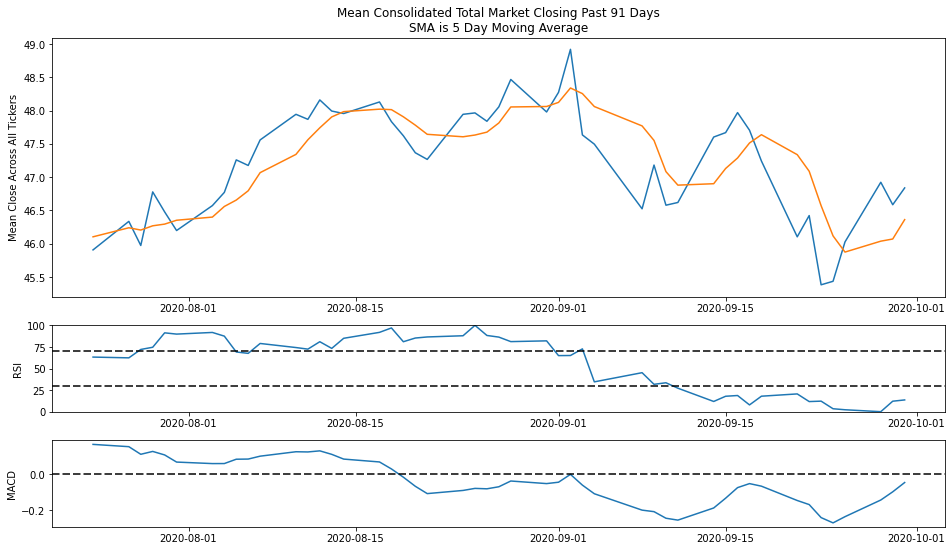

In [7]:
%matplotlib inline
Plot_Data = Total_Market
Plot_Data['RSI'] = ((Plot_Data['RSI'] -  np.min(Plot_Data['RSI'])) / (np.max(Plot_Data['RSI']) - np.min(Plot_Data['RSI'])))*100


Plot_Data['date'] = Plot_Data.index.get_level_values('date')
Plot_Data = Plot_Data.reset_index(drop = True)
x = Plot_Data['date']

fig, axs = plt.subplots(3,1,gridspec_kw={'height_ratios':[3,1,1]})
axs[0].plot(x,Plot_Data['close'])
axs[0].plot(x,Plot_Data['sma'])
axs[1].plot(x,Plot_Data['RSI'])
axs[1].axhline(y = 70,c = 'black',dashes = (5,2))
axs[1].axhline(y = 30,c = 'black',dashes = (5,2))
axs[2].plot(x,Plot_Data['MACD'])
axs[2].axhline(y = 0,c = 'black',dashes = (5,2))

axs[0].set(title = "Mean Consolidated Total Market Closing Past "+ str(N_DAYS_AGO) +" Days\nSMA is " + str(Total_Market_Plot_SMA) +" Day Moving Average",
      ylabel = "Mean Close Across All Tickers",
      xlabel = "")
axs[1].set(ylabel = "RSI",
      xlabel = "",
      ylim = [0,100])
axs[2].set(ylabel = "MACD",
      xlabel = "")
fig.set_size_inches(16,9)

## Digging Into A Sector Ranking

In [19]:
Sectors = list(Combined_Data['sector'].unique())
Sector_Summary = Group_Consolidator(Combined_Data = Combined_Data,
                                    groups = Sectors,
                                    column = 'sector'
)
Sector_Summary

,stock_count,last_period_return,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta
sector,,,,,,,,,,
Utilities,38,0.015725,50.573895,0.979899,0.001541,50.073180,0.030869,0.004555,0.332,0.575591
Technology,126,0.011393,51.271897,0.474299,0.002743,60.714264,-0.017865,0.002355,0.376,0.867453
Healthcare,104,0.001228,50.068827,1.032417,0.003324,60.072378,0.009188,0.001265,0.692,0.738219
Consumer Defensive,52,-0.001429,46.584654,0.659174,-0.000734,42.538455,-0.114012,0.000311,0.766,0.738104
Consumer Cyclical,137,-0.004481,48.037723,0.837262,-0.000298,57.426515,-0.282524,-0.000149,0.462,1.200465
Industrials,107,-0.007404,50.168850,0.631591,0.000174,29.295781,-0.216130,-0.000233,0.588,1.007008
Real Estate,62,-0.007784,42.531081,0.780971,-0.001282,41.424819,-0.243826,-0.000260,0.454,1.430657
Basic Materials,48,-0.021817,43.376188,0.619503,-0.000721,27.529171,-0.315253,-0.001761,0.544,1.317200
Communication Services,17,-0.013327,30.007469,0.635154,-0.002451,23.769827,-0.144781,-0.001782,0.460,0.856331


## Diving Further Into Individual Idustries

In [20]:
Top_Sector = Combined_Data[Combined_Data['sector'].isin(Sector_Summary.index.values)]
Industries = list(Top_Sector['industry'].unique())
Industry_Summary = Group_Consolidator(Combined_Data = Top_Sector,
                                      groups = Industries,
                                      column = 'industry',
                                      max_alpha_p = 0.50,
                                      min_alpha = 0,
                                      min_macd = 0
                                     )
Industry_Summary

,stock_count,last_period_return,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta
industry,,,,,,,,,,
Medical Diagnostics & Research,11,0.070893,53.518909,1.120116,0.007126,56.104583,0.362135,0.016881,0.082,0.832147
Utilities - Independent Power Producers,4,0.042377,48.974500,1.311805,0.003746,51.564593,0.142976,0.010113,0.066,0.639180
Semiconductors,31,0.037704,49.337032,0.672335,0.006707,55.316574,0.111607,0.007054,0.090,1.020415
Real Estate Services,3,0.016871,98.958000,0.650200,0.008464,53.585472,0.025173,0.006032,0.364,1.121711
Utilities - Regulated,34,0.012785,50.762059,1.076950,0.001294,42.479609,0.017680,0.003935,0.398,0.568614
Medical Instruments & Equipment,11,0.009197,62.077273,1.185246,0.001390,59.584833,0.005075,0.001456,0.338,0.603612


## Diving Into The Individual Stocks

In [21]:
Top_Industry = Top_Sector[Top_Sector['industry'].isin(Industry_Summary.index.values)]
Stocks = list(Top_Industry['stock'].unique())
Stock_Summary = Group_Consolidator(Combined_Data = Top_Industry,
                                   groups = Stocks,
                                   column = 'stock',
                                   max_alpha_p = 0.25,
                                   min_alpha = 0,
                                   min_macd = 0,
                                   max_rsi = 70
)
Stock_Summary. \
    sort_values(by = ['rsi'],ascending = [1])

,stock_count,last_period_return,last_price,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta
stock,,,,,,,,,,
ENTG,1,0.063399,71.288,0.661242,0.009859,43.307336,0.426349,0.012899,0.120,0.449213
ES,1,0.039859,82.328,0.987227,0.000325,43.738409,0.014873,0.010050,0.238,0.632857
CRUS,1,0.068027,64.586,0.489826,0.011759,46.946702,0.653578,0.013780,0.100,0.806613
ED,1,0.030525,76.160,0.972962,0.004871,52.497753,0.273064,0.007603,0.184,0.545096
PEG,1,0.048447,54.332,1.730106,0.003597,53.851420,0.248156,0.012774,0.100,0.506941
AMAT,1,0.033509,58.900,0.556044,0.005482,57.072544,0.384669,0.005890,0.186,0.388078
ORA,1,0.049116,58.266,1.034039,-0.000251,61.643266,0.116793,0.013381,0.210,0.631237
QGEN,1,0.029352,51.820,0.305812,0.004216,63.424367,0.154797,0.007617,0.086,-0.071371
NTRA,1,0.121787,69.692,1.300912,0.011633,64.886577,0.394310,0.024998,0.096,0.892992
